In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**RICE PADDY DISEASE CLASSIFICATION**

   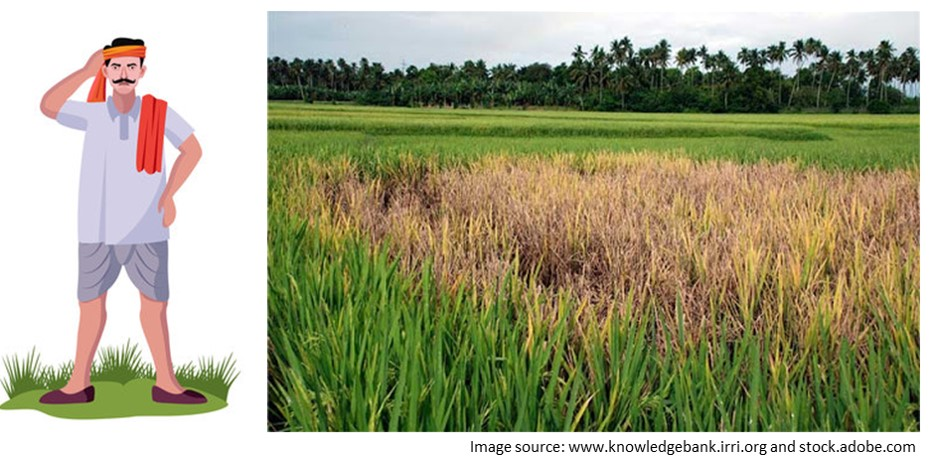

**Problem Statement**

Rice (Oryza sativa) is one of the staple foods worldwide. Paddy, the raw grain before removal of husk, is now beimg cultivated in Afrcan climates, mainly in countries like Nigeria. Paddy cultivation requires consistent supervision because several diseases and pests might affect the paddy crops, leading to up to 70% yield loss. Expert supervision is usually necessary to mitigate these diseases and prevent crop loss. With the limited availability of crop protection experts, manual disease diagnosis is tedious and expensive. Thus, it is increasingly important to automate the disease identification process by leveraging computer vision-based techniques that achieved promising results in various domains.

**Objective**

The main objective of this project is to develop a machine or deep learning-based model to classify the given paddy leaf images accurately. We have a training dataset of 10,407 labeled images across ten classes (nine disease categories and normal leaf). Moreover, also provided are additional metadata for each image, such as the paddy variety and age. The task is to be able to classify paddy images into one of the nine disease categories or a normal leaf.

**Acknowledgements**

We acknowledge the Paddy Doctor project team at the Department of Computer Science and Engineering, Manonmaniam Sundaranar University, Tirunelveli, India, and its collaborators.

Kaggler Aayush Chaudhary(your approach helped in building my second model).


**Importing Modules**

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import tensorflow as tf
from tensorflow.keras import models, layers

# # disable all debugging logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

**Importing Data**

In [2]:
dir = os.listdir('../input/paddy-disease-classification')
# for filenames in dir:
#     print(filenames)

In [7]:
!cp -rf ../input/paddy-disease-classification/train_images ./train_images

In [8]:
!cp -rf ../input/paddy-disease-classification/test_images ./test_images

**Analyze Train.csv for data Insights**

In [3]:
train = pd.read_csv('../input/paddy-disease-classification/train.csv')
train.head()

In [6]:
train.info()

In [7]:
print(train['label'].unique())
print(train['variety'].unique())

In [8]:
plt.figure(figsize=(12,12))
sns.countplot(x='label', data=train)
plt.title('Countplot of the classification labels')
plt.xticks(rotation=45)
plt.show()

In [9]:
plt.figure(figsize=(12,12))
sns.countplot(x='variety', data=train)
plt.title('Countplot of the classification labels')
plt.xticks(rotation=45)
plt.show()

**Observations from the plots**
* In the first plot it was observed that the label column features were not evenly distributed, with blast, tungro, dead heart, hispa, normal and brown spot consisting of most ofthe data. This shows that building a model with this data will have a bias towards the more prevelant labels than the rest.
* In the second plot, it was observed that most of the image data were of ADT45 variety, which will lead to a very obvious bias to the variety.

In [10]:
plt.figure(figsize=(12,12))
sns.histplot(x=train['age'], bins=7, kde=True)
plt.title('Age distribution of the Paddy')
plt.show()

The Age distribution plot above shows the distribution of the age of the paddy, with the plot resembling a trimodal distribution, having two (2) minor peaks and a major peak where a majority of the data is located. This simply means the age is spread out between three modal ranges, which have the most frequency.

In [11]:
plt.figure(figsize=(12,12))
sns.boxplot(x='age', y='label', data=train)
plt.title('Boxplot of each label age')
plt.show()

The boxplot above shows the summary of the Interquartile range of the age feature across the labels of the data,
The plot shows the presence of outliers in the dead_heart label and the normal label (represeted by the dots) which shoulded be removed as outliers tend to affect our training process.

In [12]:
plt.figure(figsize=(12,12))
sns.boxplot(x='age', y='variety', data=train)
plt.title('Boxplot of each variety age')
plt.show()

This plot is similar to the above boxplot but instead of the label feature it shows the summary of the Interquartile range of the age feature across the variety feature column. 

NB: if you recall the variety column is highly populated with the ADT45 variety and hence not evenly distributed in the slightest, so most of the boxplot insights are heavily favoured towards the more populated varietys.

In [13]:
plt.figure(figsize=(12,12))
sns.histplot(x='age', hue='label', data=train)
plt.title('Age distribution across the classification labels')
plt.xticks(rotation=45)
plt.show()

This plot above shows the distribution of the classification labels across the age of the paddies.
A few insights can be observed at a glance, such as the absence of the normal classifiication labels between the early and later ages. Also the presence of blast in the early and late(but not latter) stages.

A similar plot with age distribution across varieties would give no significant insight as the varieties do not change with age and are set in geneology and the abundance of the ADT45 variety in the data.

In [14]:
plt.figure(figsize=(12,12))
sns.histplot(data=train, x='label', hue='variety')
plt.title('Disease across varieties')
plt.xticks(rotation=45)
plt.show()

This plot shows the relationship between the labels and the variety features at first glance it might look redundant but if you look closer you can observe that the ADT45 variety is absent in the bacterial leaf streak classification label. Ths might prompt futher research into the label calssification and the varieties affected and not affected 

INSIGHTS FROM THE DATA

* The label classifications and varieties are not evenly distributed, which will obviously lead to bias.
* As shown in the data we will look to eliminate outliers in the normal and dead heart classifications.
* The label classifications distributions on the age column shows a correlation between the age of the plant and its healthyness as the normal classification is located within a range of age values.
* The absence of a variety in a label classification

These insights can inspire futher research to either improve the data or highlight possible biases which the model might have when predicting.

In [15]:
print(len(train[(train['label']=='dead_heart') & (train['age'] < 65)]))
print(len(train[train['label']=='dead_heart']))
# train[(train['label']=='dead_heart') & (train['age'] < 65)]

In [16]:
print(len(train[(train['label']=='normal') & (train['age'] > 78)]))
print(len(train[train['label']=='normal']))
# train[(train['label']=='normal') & (train['age'] > 78)]

As earlier highlighted some label clasifications in our data contain ouliers, as seen above we will like to be able to identify these images with the ouliers 

In [17]:
id = []
for index, row in train.iterrows():
    if row['label'] == 'dead_heart' and row['age'] < 65:
        id.append(row['image_id'])
    elif row['label'] == 'normal' and row['age'] > 78:
        id.append(row['image_id'])
        
print(len(id))

In [18]:
outlier_id = id
print(outlier_id[:11])

****Engage the Dataset in Kaggle/Working Dir.****

In [5]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path('/kaggle/input/paddy-disease-classification/train_images/')
print(dataset_dir)

In [4]:
class_labels = list(np.unique(train['label']))
class_labels

Global Initialization of Some Variables

In [6]:
Image_Size = (680, 480)
Batch_Size = 32
Channels = 3
EPOCHS = 32

Data Pipeline Initialization

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                        dataset_dir,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=class_labels,
                                                        color_mode='rgb',
                                                        image_size=Image_Size,
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        seed=42,
                                                        batch_size=Batch_Size)

val_dataset =  tf.keras.preprocessing.image_dataset_from_directory(
                                                        dataset_dir,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=class_labels,
                                                        color_mode='rgb',
                                                        image_size=Image_Size,
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='validation',
                                                        seed=42,
                                                        batch_size=Batch_Size)

In [23]:
print(len(train_data))
print(len(val_data))
print(train_data)

In [24]:
# Exploring images in a single Batch
for images, labels in train_data.take(1):
    print(images[0].numpy())
    print(images[0].shape)
    print(labels.numpy()) 

In [ ]:
class_labels = train_data.class_names
class_labels

In [26]:
# Explore an Image and its Label
for image, label in train_data.take(1):            #take a single value from a batch
    plt.imshow(image[0].numpy().astype('uint8'))   #plot the numpy values of a single image in a batch
    plt.axis('off')                                 
    plt.title(class_labels[label[0].numpy()])     #show the categorical label as the title

In [27]:
# Exploring Multiple Images
plt.figure(figsize=(12,12))
for image_batch, label_batch in train_data.take(1):
    for i in range(15):
        plt.subplot(5,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_labels[label_batch[i]])

**Caching,Shuffling and Prefetching the data for training Optimization**

In [28]:
# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Image Optimization and Image Augumentation Layers**

In [12]:
# Image Preprocessing Process: Rescaling and Resizing
img_size = 400
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size, img_size),
#     layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data augmentation 
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.3),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

Inception-V3 Model Layer

In [10]:
input_shape=(img_size, img_size, Channels)
inception_model = tf.keras.applications.InceptionV3(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
inception_model.trainable = False

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
dropout_layer = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(10, activation='softmax')

In [26]:
inputs = tf.keras.Input(shape=(680, 480, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = tf.keras.applications.inception_v3.preprocess_input(x, data_format=None)
x = inception_model(x, training=False)
x = global_average_layer(x)
x = dense_layer_1(x)
x = dropout_layer(x)
x = dense_layer_2(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
incep_model = tf.keras.Model(inputs, outputs)

In [29]:
base_learning_rate = 0.001
incep_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [27]:
incep_model.summary()

Creating First Baseline Model 

In [30]:
history0 = incep_model.fit(
    train_dataset, 
    epochs = 15,  
    validation_data = val_dataset
#     callbacks=[early_stopping]
)

Analysing our Baseline Model

In [31]:
# Getting the model history parameters

train_loss = history0.history['loss']
train_acc = history0.history['accuracy']

val_loss = history0.history['val_loss']
val_acc = history0.history['val_accuracy']

In [32]:
#graphs showing accuracy and loss of training and validation data

plt.figure(figsize = (20,20))
plt.subplot(2,3,1)
plt.plot(range(15), train_acc, label = 'Training Accuracy')
plt.plot(range(15), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(15), train_loss, label = 'Training_Loss')
plt.plot(range(15), val_loss, label = 'Validation_Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

Observing the training and validation loss and accuracy plots we can observe that the model is underfit and adding more epochs will likely solve this problem. Also we will carry out data balancing to try and solve the imbalace data problem our current data has.

In [21]:
print("Number of layers in the base model: ", len(inception_model.layers))

In [34]:
for layer1 in inception_model.layers[245:]:
    layer1.trainable=True

In [35]:
incep_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [36]:
callback2=tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

In [37]:
history0_tuned=incep_model.fit(train_dataset, validation_data=val_dataset, epochs=40, initial_epoch=history0.epoch[-1], callbacks=[callback2] )

In [38]:
acc += history0_tuned.history['accuracy']
val_acc += history0_tuned.history['val_accuracy']

loss += history0_tuned.history['loss']
val_loss += history0_tuned.history['val_loss']

In [45]:
initial_epochs = 15

plt.figure(figsize = (20,20))
# plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
model_version = 11
incep_model.save('incep_model.h5')
incep_model.save(f'./{model_version}')

**Creating Second Model**

We will be generating class weights to try and tackle the data imbalance problem and we will also be increasing our number of epochs to enable more convergence between our training and validation accuracy and losses.

In [7]:
train_df = pd.read_csv('../input/paddy-disease-classification/train.csv')
train_df.tail()

In [8]:
class_labels = list(np.unique(train['label']))
class_labels

In [9]:
EPOCH = 100

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=4, verbose=1,  factor=0.2, min_lr=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)

In [10]:
train_data= tf.keras.utils.image_dataset_from_directory("/kaggle/input/paddy-disease-classification/train_images/",
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=class_labels,
                                                        color_mode='rgb',
                                                        image_size=(400,400),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        seed=42)

val_data= tf.keras.utils.image_dataset_from_directory("/kaggle/input/paddy-disease-classification/train_images/",
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=class_labels,
                                                        color_mode='rgb',
                                                        image_size=(400,400),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='validation',
                                                        seed=42)

In [11]:
base_model=tf.keras.applications.EfficientNetB2(include_top=False, pooling='avg', weights='imagenet', input_shape=(400,400,3))

In [13]:
inputs=tf.keras.Input(shape=(400,400,3))
x=data_augmentation(inputs)
x=base_model(x, training=False)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dropout(0.4)(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dropout(0.4)(x)
output=tf.keras.layers.Dense(10, activation='softmax')(x)
model=tf.keras.Model(inputs,output)

In [14]:
model.summary()

In [15]:
print("Number of layers in the base model: ", len(base_model.layers))

In [17]:
for layer in base_model.layers:
    layer.trainable=False

In [18]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [19]:
callback1=tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2, restore_best_weights=True)

In [20]:
history=model.fit(train_data, validation_data=val_data, epochs=15, callbacks=[callback1])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
for layer1 in base_model.layers[250:]:
    layer1.trainable=True

In [25]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

In [26]:
callback2=tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

In [ ]:
history_tuned=model.fit(train_data, validation_data=val_data, epochs=55, initial_epoch=history.epoch[-1], callbacks=[callback2] )

In [128]:
acc += history_tuned.history['accuracy']
val_acc += history_tuned.history['val_accuracy']

loss += history_tuned.history['loss']
val_loss += history_tuned.history['val_loss']

In [130]:
initial_epochs = 15
plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
test_data=tf.keras.utils.image_dataset_from_directory("/kaggle/input/paddy-disease-classification/test_images/",
                                                        labels=None,
                                                        label_mode=None,
                                                        color_mode='rgb',
                                                        image_size=(400,400),
                                                        shuffle=False)

In [135]:
test_prediction = tf.argmax(model.predict(test_data), axis=-1)

In [142]:
test_predictions=[]
for i in test_prediction:
    test_predictions.append(class_labels[i])

In [143]:
test_predictions = pd.Series(test_predictions)

In [138]:
submission_df = pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')

In [144]:
submission_df['label'] = test_predictions

In [145]:
submission_df.head()

In [146]:
submission_df.to_csv('Rice Paddy Doctor TF2 .csv',index=None)

In [147]:
model_version = 77
model0.save('basemodel.h5')
model0.save(f'./{model_version}')

**Final Thoughts and Posiible Model Improvement Methods**

The Effinet Transfer learning model gave the more accurate model in contrast to the Inception V3 model, running at the same epochs and fine tuning methods. Possible model improvement methods involve;

* Trying to remove the outliers as discovered during data analysis of the data csv file.
* Increasing the number of epochs when training or fine tuning any of the models.
* Trying out different fine-tuning practices such as reducing the learning rate in the presence of a plateau in the training graph.